<a href="https://colab.research.google.com/github/RileyWClarke/BiancoGroup/blob/master/Notebooks/fftfilter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


#Potentially useful astropy stuff
import astropy
import astropy.io.ascii as ascii
from astropy.table import Table
from astropy.io import fits
from astropy.stats import LombScargle
from astropy.stats import sigma_clipped_stats
from astropy.stats import sigma_clip
from astropy.modeling import powerlaws
from astropy import constants as const
from astropy import units as u

#For reading in and organizing data
import pandas as pd
import requests
import json

#Misc
import scipy
from scipy import stats
from scipy.optimize import curve_fit
from collections import Counter
import itertools
from sklearn.preprocessing import scale

#Making Figures look nice
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 18

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Data Collection/Cleaning

In [5]:
k2targs = pd.read_csv('/content/gdrive/My Drive/hlsp_k2varcat_k2_lightcurve_c00-c04_kepler_v2_catalog.csv')
k2targs.head()

,# ID,Campaign,Class,Class Probs (DSCUT,EA,EB,GDOR,Noise,OTHPER,RRab),Anomaly Score
0,202059070,0,Noise,0.004195,0.120507,0.016615,0.005925,0.604636,0.246088,0.002034,0.023891
1,202059073,0,Noise,0.000000,0.000760,0.000037,0.000180,0.851359,0.147664,0.000000,0.003344
2,202059074,0,Noise,0.000086,0.003688,0.000218,0.007253,0.547118,0.441569,0.000067,0.083032
3,202059078,0,Noise,0.000523,0.002839,0.000332,0.000105,0.888648,0.107552,0.000000,0.000000
4,202059080,0,Noise,0.038219,0.082267,0.022758,0.058409,0.614507,0.078915,0.104926,0.136364


In [6]:
targets = k2targs[['# ID', ' Campaign']].values
targets

array([[202059070,         0],
       [202059073,         0],
       [202059074,         0],
       ...,
       [211203438,         4],
       [211203556,         4],
       [211203589,         4]])

In [7]:
toi_inds = [np.where(targets[:,0] == 211046195)[0][0],
        np.where(targets[:,0] == 210327027)[0][0],
        np.where(targets[:,0] == 211110493)[0][0]]

toi_inds

[66503, 53566, 68032]

In [8]:
urls = ['https://archive.stsci.edu/missions/k2/lightcurves/c'
        +str(target[1])+'/'+str(target[0])[0:4]+'00000/'
        +str(target[0])[4:6]+'000/ktwo'+str(target[0])
        +'-c0'+str(target[1])+'_llc.fits' for target in targets]
urls[::5000]

['https://archive.stsci.edu/missions/k2/lightcurves/c0/202000000/59000/ktwo202059070-c00_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c0/202000000/91000/ktwo202091770-c00_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201200000/35000/ktwo201235947-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201500000/09000/ktwo201509462-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201600000/98000/ktwo201698027-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201800000/93000/ktwo201893576-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c2/203500000/89000/ktwo203589087-c02_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c2/204700000/54000/ktwo204754843-c02_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c3/205900000/32000/ktwo205932262-c03_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c3/206000000/89000/ktwo206089354-c03_llc.fits',


In [9]:
toi_urls = [urls[toi] for toi in toi_inds]
toi_urls

['https://archive.stsci.edu/missions/k2/lightcurves/c4/211000000/46000/ktwo211046195-c04_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c4/210300000/27000/ktwo210327027-c04_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c4/211100000/10000/ktwo211110493-c04_llc.fits']

In [10]:
#Read in arrays via astropy.fits.open
def urls_to_dict(urls, campaign):
  d = {}
  for j, url in enumerate(urls):
    print()
    if url[51] == campaign:
      try:
        with fits.open(url, mode="readonly") as hdulist:
          d["k2bjds{0}".format(j)] = hdulist[1].data['TIME'] 
          d["pdcsap_flux{0}".format(j)] = hdulist[1].data['PDCSAP_FLUX']
          d["pdcsap_flux_err{0}".format(j)] = hdulist[1].data['PDCSAP_FLUX_ERR']

      except: 
        print('Loop '+str(j)+' : File not found')

  return d

In [ ]:
d0 = urls_to_dict(urls[:1000], campaign='0')

In [11]:
dtoi = urls_to_dict(toi_urls, campaign='4')

In [ ]:
#How many objects did we grab total?
len(d0)/3

In [ ]:
nanseries = []
for filename in d0:
  nanseries.append(d0[filename])

In [ ]:
!pwd

/content


In [ ]:
!cd gdrive

In [ ]:
!ls

gdrive	sample_data


In [ ]:
np.save('gdrive/My Drive/nanseries', nanseries)

In [13]:
nanseries = np.load('gdrive/My Drive/nanseries.npy')

In [14]:
bjds = nanseries[::3]
fluxes = nanseries[1::3]
fluxerrs = nanseries[2::3]

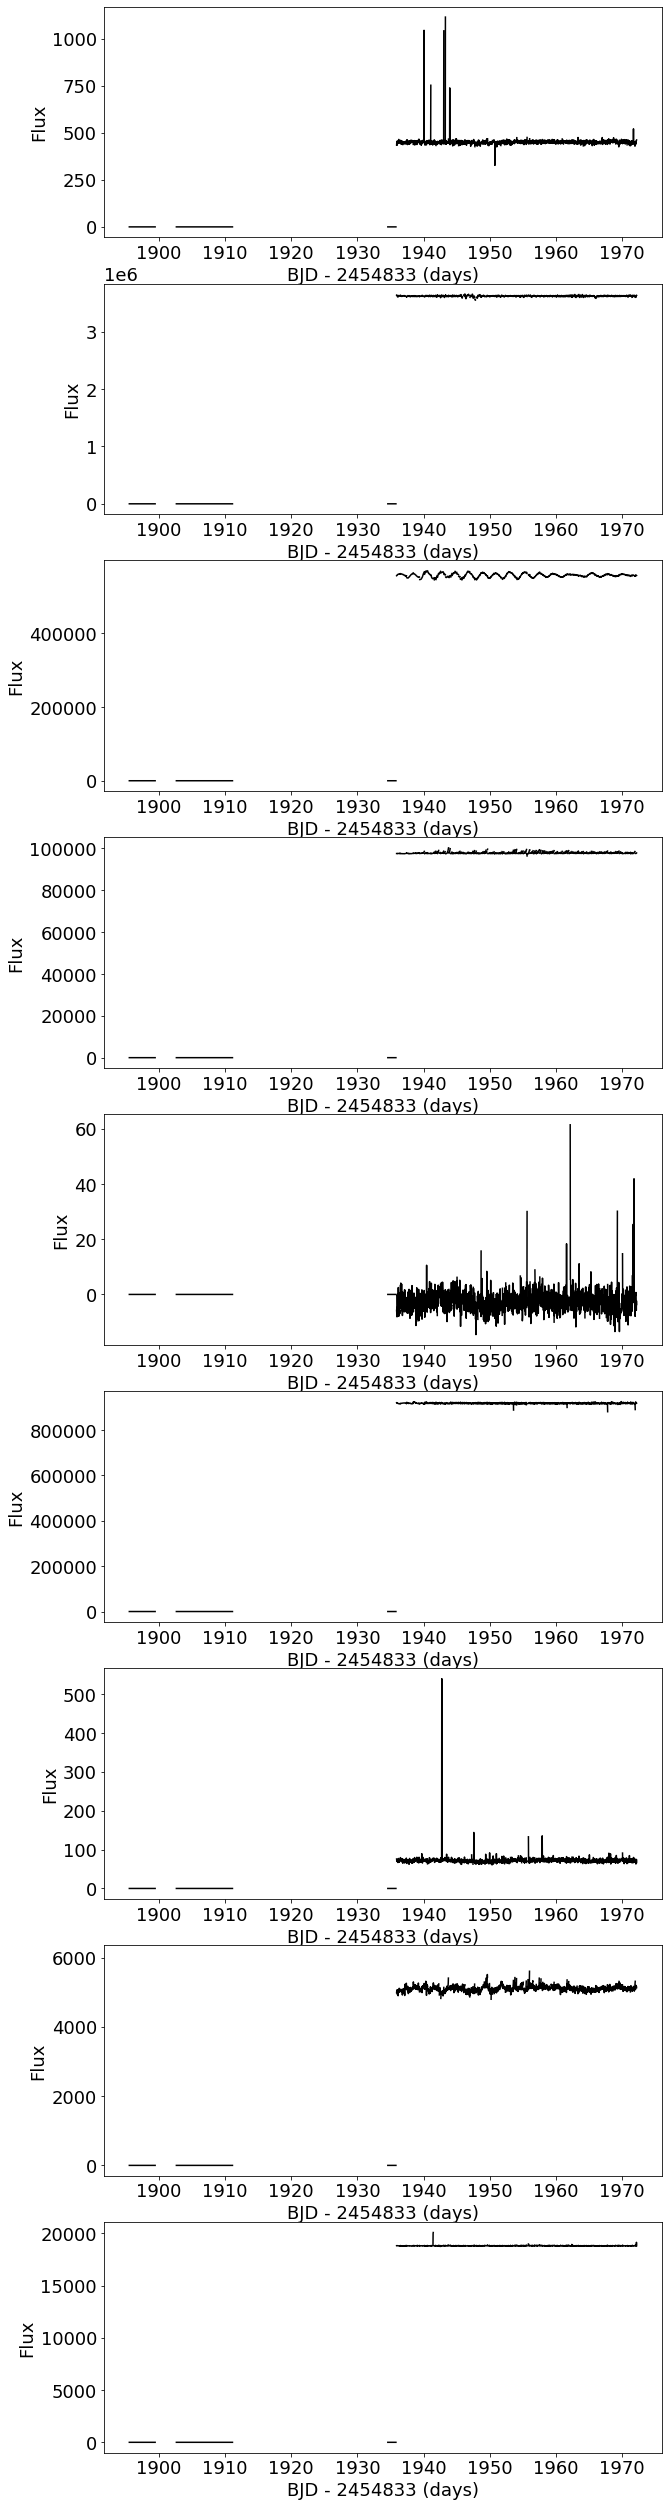

In [15]:
fig, axes = plt.subplots(9, figsize=(10,45))
p = 0
for i in range(0,900,100):
  #fluxes[i] = (fluxes[i] - np.nanmean(fluxes[i])) / np.nanstd(fluxes[i])
  axes[p].plot(bjds[i], fluxes[i], c='k')
  axes[p].set_ylabel('Flux')
  axes[p].set_xlabel('BJD - 2454833 (days)')
  p += 1
plt.savefig('gdrive/My Drive/nanseries.png', dpi=100)


In [16]:
#Remove initial data gap
def trunc(bjds, fluxes, fluxerrs, start):
  l1 = []
  l2 = []
  l3 = []
  for i in range(len(bjds)):
    l1.append(bjds[i][start:])
    l2.append(fluxes[i][start:])
    l3.append(fluxerrs[i][start:])

  return l1, l2, l3

In [17]:
start = np.where(np.abs(fluxes[0]) >= 1)[0][0]
bjds, fluxes, fluxerrs = trunc(bjds, fluxes, fluxerrs, start)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


In [18]:
#Normalize flux values
for i in range(len(fluxes)):
  fluxes[i] = (fluxes[i] - np.nanmean(fluxes[i])) / np.nanstd(fluxes[i])

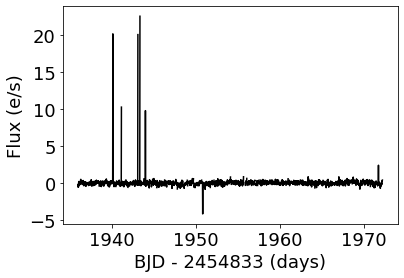

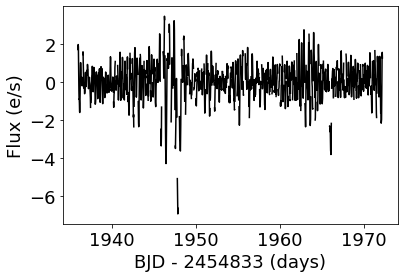

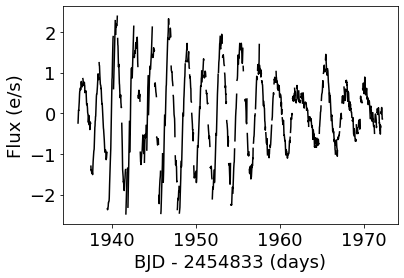

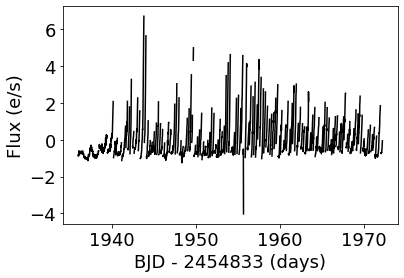

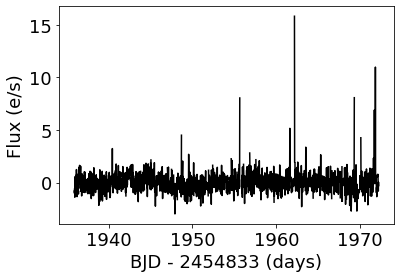

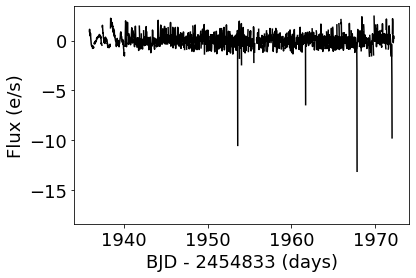

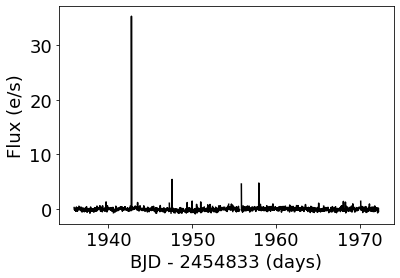

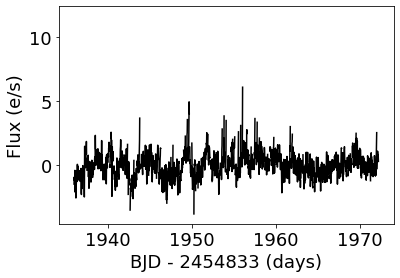

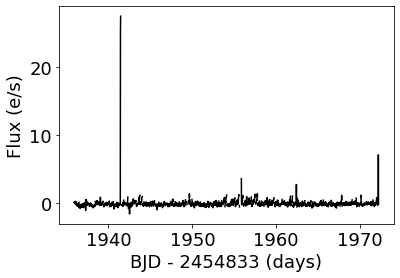

In [19]:
for i in range(0,900,100):
  plt.plot(bjds[i], fluxes[i], c='k')
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Flux (e/s)')
  plt.show()

In [20]:
#Test for NaNs:
a = []
for j in range(len(bjds)):
  a.append(np.any(np.isnan(bjds[j]) == True))
  a.append(np.any(np.isnan(fluxes[j]) == True))
  a.append(np.any(np.isnan(fluxerrs[j]) == True))
np.any(a)#If NaNs exist, this returns True

True

In [21]:
#Build list of # of consectutive nans + their indices in series
bjd_gaps = []
flux_gaps = []
fluxerr_gaps = []

for bjd in bjds:
  nancount = 0
  for i in range(len(bjd)):
    if (np.isnan(bjd[i]) == True) and (np.isnan(bjd[i+1]) == False):
      nancount += 1
      bjd_gaps.append(nancount)
      nancount = 0

    if (np.isnan(bjd[i]) == True) and (np.isnan(bjd[i+1]) == True):
      nancount += 1

for flux in fluxes:
  nancount = 0
  for i in range(len(flux)):

    if (np.isnan(flux[i]) == True) and (np.isnan(flux[i+1]) == False):
      nancount += 1
      flux_gaps.append(nancount)
      nancount = 0

    if (np.isnan(flux[i]) == True) and (np.isnan(flux[i+1]) == True):
      nancount += 1

for fluxerr in fluxerrs:
  nancount = 0
  for i in range(len(fluxerr)):
    if (np.isnan(fluxerr[i]) == True) and (np.isnan(fluxerr[i+1]) == False):
      nancount += 1
      fluxerr_gaps.append(nancount)
      nancount = 0

    if (np.isnan(fluxerr[i]) == True) and (np.isnan(fluxerr[i+1]) == True):
      nancount += 1

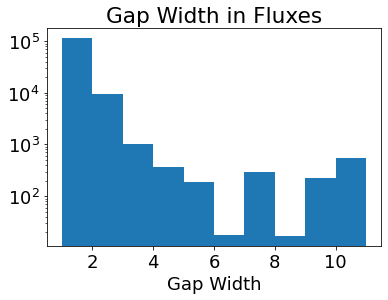

In [22]:
plt.hist(flux_gaps)
plt.yscale('log')
plt.xlabel('Gap Width')
plt.title('Gap Width in Fluxes')
plt.savefig('nanhist', dpi=200)

## Linear Interpolation

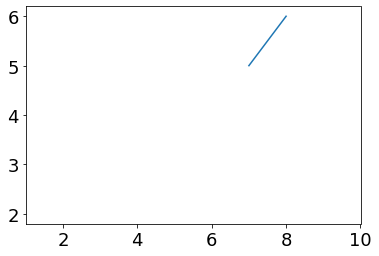

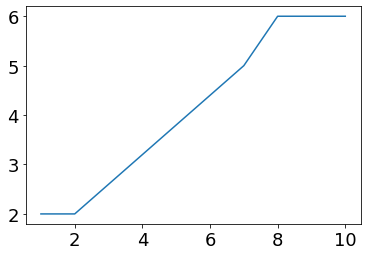

In [23]:
#Simple linear interpolation model:
x = [1,2,3,4,5,6,7,8,9,10]
y = [np.nan,2,np.nan,np.nan,np.nan,np.nan,5,6,np.nan,np.nan]

plt.plot(x,y)
plt.xlim(1,10)
plt.show()

if np.isnan(y[0]) == True:
  for i,j in enumerate(y):
    if np.isnan(j) == False:
      y[:i] = np.full(i, j)
      break
    else:
      pass

if np.isnan(y[-1]) == True:
  for i,j in enumerate(y[::-1]):
    if np.isnan(j) == False:
      y[-i:] = np.full(i, j)
      break
    else:
      pass

bools = np.isnan(y)
edges = np.diff(bools)
edgeindx = np.where(~(edges == 0))[0]+1

for i, edge in enumerate(edgeindx):
  if i%2 == 0:

    a, b = np.polyfit((x[edge-1], x[edgeindx[i+1]]), (y[edge-1], y[edgeindx[i+1]]) , 1)
    ynew = a * np.array(x[edge:edgeindx[i+1]]) + b

  else:
    continue
  
  y[edge:edgeindx[i+1]] = ynew

plt.plot(x,y)

In [24]:
def lin_interp_nans(time, flux):
    newflux = np.copy(flux)

    #if series tip/tail is nan, replace with first/last real value:

    if np.isnan(newflux[0]) == True:
      for i,j in enumerate(newflux):
        if np.isnan(j) == False:
          newflux[:i] = np.full(i, j)
          break
        else:
          pass

    if np.isnan(newflux[-1]) == True:
      for i,j in enumerate(newflux[::-1]):
        if np.isnan(j) == False:
          newflux[-i:] = np.full(i, j)
          break
        else:
          pass

    #patching:
    bools = np.isnan(newflux)
    edges = np.diff(bools)
    edgeindx = np.where(~(edges == 0))[0]+1
    
    for i, edge in enumerate(edgeindx):
    
      if i%2 == 0:
      
        a, b = np.polyfit( (edge-1, edgeindx[i+1]),
                           (flux[edge-1], flux[edgeindx[i+1]]), deg = 1)
        
        patch = a * np.arange(edge,edgeindx[i+1]) + b 
        
      else:
        continue

      newflux[edge:edgeindx[i+1]] = patch
      
    return newflux

In [25]:
#Interpolate the flux arrays:
for i, flux in enumerate(fluxes):
  fluxes[i] = lin_interp_nans(bjds[i], flux)

In [26]:
#Test for NaNs:
a = []
for j in range(len(fluxes)):
  a.append(np.any(np.isnan(fluxes[j]) == True))
np.any(a)#If NaNs exist, this returns True

False

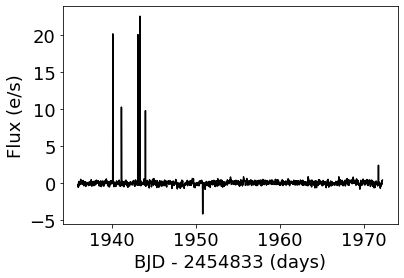

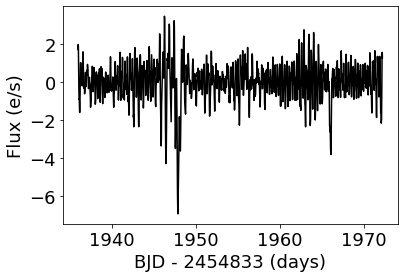

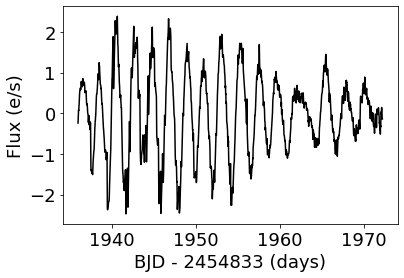

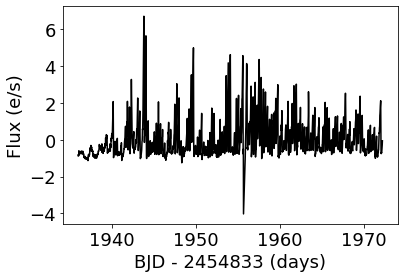

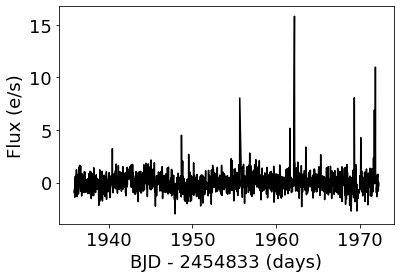

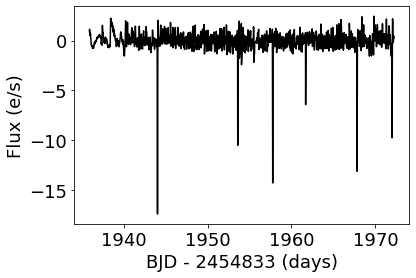

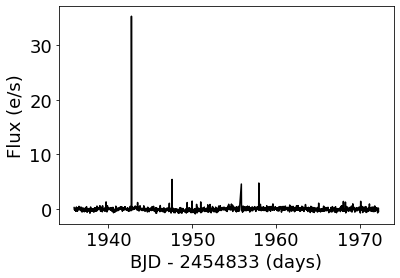

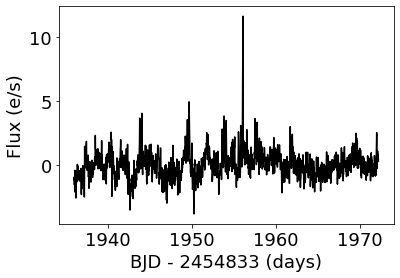

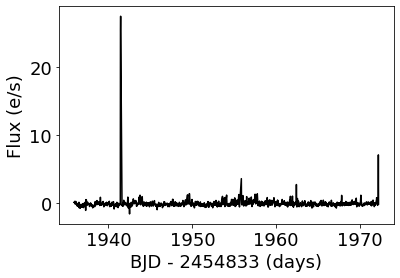

In [27]:
for i in range(0,900,100):
  plt.plot(bjds[i], fluxes[i], c='k')
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Flux (e/s)')
  plt.show()

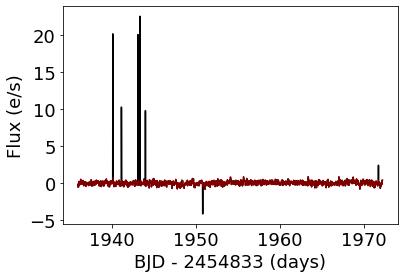

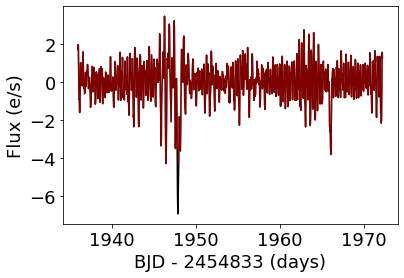

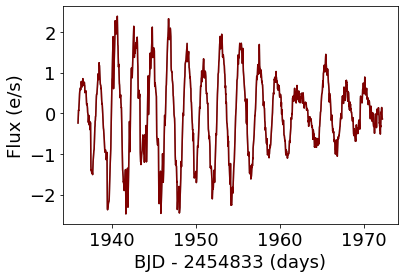

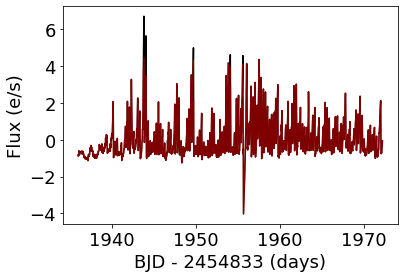

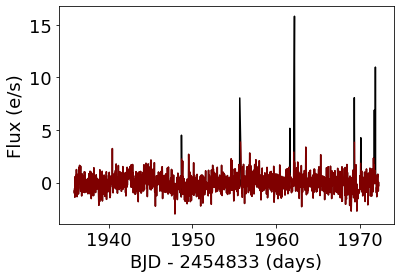

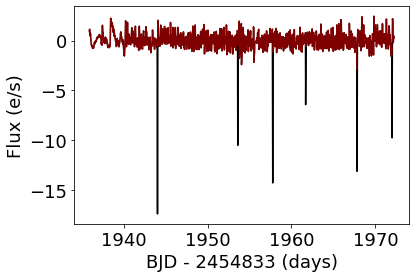

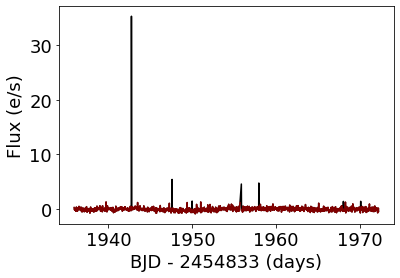

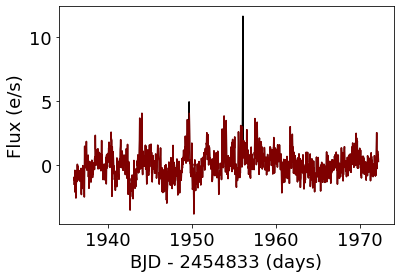

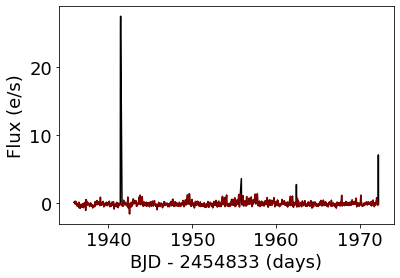

In [28]:
for i in range(0,900,100):
  plt.plot(bjds[i], fluxes[i], c='k')
  plt.plot(bjds[i], sigma_clip(fluxes[i], sigma=5), c='r', alpha=0.5)
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Flux (e/s)')
  plt.show()

In [29]:
clippedfluxes = []
for i in range(len(fluxes)):
  clippedfluxes.append(sigma_clip(fluxes[i], sigma=3))

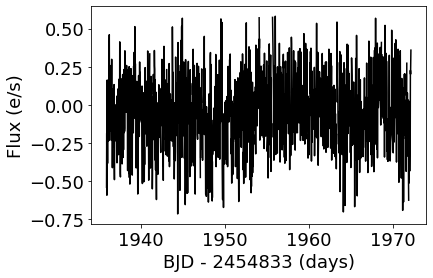

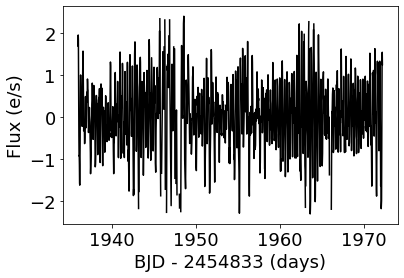

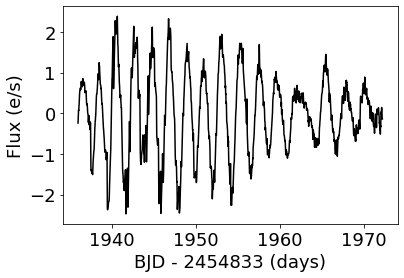

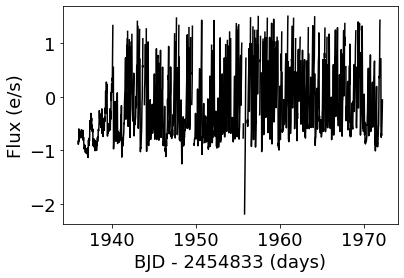

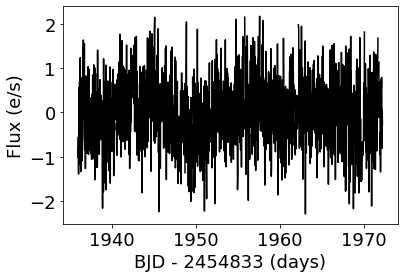

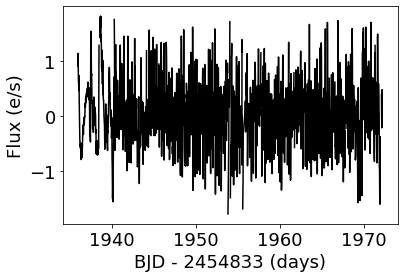

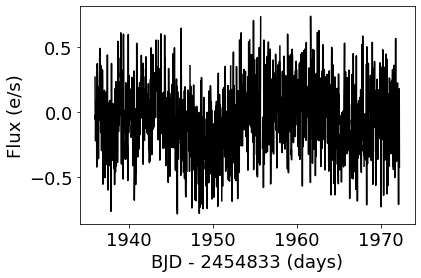

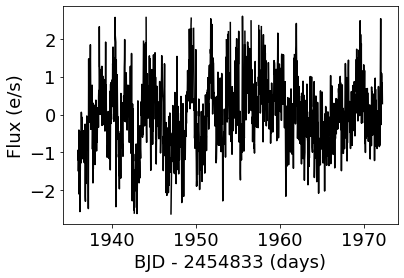

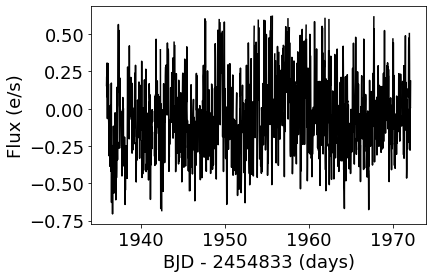

In [30]:
for i in range(0,900,100):
  plt.plot(bjds[i], clippedfluxes[i], c='k')
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Flux (e/s)')
  plt.show()

# FFT Filtering

In [31]:
def invgaussian(m, s, x):
    g = -np.exp(-(m-x)**2 / s**2) + 1 
    return g

In [32]:
def bandpass_ifft(t, flux, low_cutoff, high_cutoff, sample=1, 
                  M=None, inv_box=False, gf_sig = 1, Filter='box', Plot=''):
    """Bandpass filtering on a real signal using inverse FFT
    
    Inputs
    =======
    
    X: 1-D numpy array of floats, the real time domain signal (time series) to be filtered
    Low_cutoff: float, frequency components below this frequency will not pass the filter (physical frequency in unit of Hz)
    High_cutoff: float, frequency components above this frequency will not pass the filter (physical frequency in unit of Hz)
    sample: float, the sampling frequency of the signal (physical frequency in unit of Hz)    
    M: idk lmao
    inv_box: If using box filter, setting inv=True filters out frequencies outside the box
    Filter: Default filter is box, can choose 'Gaussian' also
    
    Notes
    =====
    1. The input signal must be real, not imaginary nor complex
    2. The Filtered_signal will have only half of original amplitude. Use abs() to restore. 
    3. In Numpy/Scipy, the frequencies goes from 0 to F_sample/2 and then from negative F_sample to 0. 
    
    """        
    #perform fft
    spectrum = np.fft.rfft(flux) 
    freq = np.fft.rfftfreq(len(flux), sample)
    freq_sort = np.sort(spectrum)
    
    #calculate the index of the cut off points
    lc = np.abs(freq) < Low_cutoff
    hc = np.abs(freq) > High_cutoff
    between = ~(lc + hc)
    
    ps = np.abs(spectrum)**2
    if ('PS' in Plot) or ('All' in Plot):
      plt.plot(freq, ps)
      plt.title("power spectrum")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Power Spectral Density')
      #plt.xlim(0,100)
      #plt.savefig('Figures/spec.png', bbox_inches='tight', pad_inches=0.5)
      plt.show()

    if ('DFT' in Plot) or ('All' in Plot):
      plt.plot(freq, spectrum)
      #plt.plot(freq[between], spectrum[between], alpha=0.5)
      plt.title("real fourier transform ")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Amplitude')
      #plt.xlim(0,100)
      #plt.savefig('Figures/fft.png', bbox_inches='tight', pad_inches=0.5)
      plt.show()
    
    
    
    if Filter == 'box':
    
      #filtered_spectrum = spectrum.copy()
    
      if inv_box == True:
        x_1 = np.arange(0, Low_cutoff, 0.1)
        x_2 = np.arange(High_cutoff, np.max(freq), 0.1)
        plt.plot(freq, spectrum)
        plt.fill_between(x_1, [plt.ylim()[0]] * len(x_1), 
                     [plt.ylim()[1]] * len(x_1), color='r', alpha=0.3)
        plt.fill_between(x_2, [plt.ylim()[0]] * len(x_2), 
                     [plt.ylim()[1]] * len(x_2), color='r', alpha=0.3)
        plt.title("range to suppress")
        plt.figure()
        filtered_spectrum[lc] = 0.
        filtered_spectrum[hc] = 0.
      else:
        x_ = np.arange(Low_cutoff, High_cutoff, 0.1)
        plt.plot(freq, spectrum)
        plt.fill_between(x_, [plt.ylim()[0]] * len(x_), 
                     [plt.ylim()[1]] * len(x_), color='r', alpha=0.3)
        plt.title("range to suppress")
        plt.figure()
        filtered_spectrum[between] = 0.
    
    if Filter == 'Gaussian':
      ig = invgaussian(np.median([low_cutoff,high_cutoff]), gf_sig, freq)
      filtered_spectrum = spectrum * ig
      if ('filter' in Plot) or ('All' in Plot):
        plt.plot(freq, ig)
        plt.title('Gaussian Filter')
        #plt.savefig('Figures/gfilter.png')
        #plt.xlim(0,100)
        plt.figure()

    if ('spec_filtered' in Plot) or ('All' in Plot):
      plt.plot(freq, filtered_spectrum, label="filtered spectrum")
      plt.plot(freq, spectrum, c='k', ls="--", label="spectrum", alpha=0.5)
      plt.title("Unfiltered vs. Filtered Spectrum")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Amplitude')
      ldg = plt.legend(fontsize=12)
      #plt.xlim(0,100)
      #plt.savefig('Figures/filter_compare.png', bbox_inches='tight', pad_inches=0.5)
      plt.figure()

    filtered_signal = np.fft.irfft(filtered_spectrum)  # Construct filtered signal

    if ('signal_filtered' in Plot) or ('All' in Plot):
      fig = plt.figure(figsize=(15,10)) 
      plt.plot(t, filtered_signal, label="filtered signal")
      plt.plot(t, flux, c='k', ls="--", label="original signal", alpha=0.5)
      plt.xlabel('Time')
      plt.ylabel('Amplitude')
      plt.title("Unfiltered vs. Filtered Signal")
      #plt.savefig('Figures/filtered_signal.png', bbox_inches='tight', pad_inches=0.5)
      plt.legend()
      #Filtered_signal = np.zeros_like(Filtered_signal)
    return spectrum, freq, filtered_spectrum, filtered_signal, Low_cutoff, High_cutoff

In [33]:
dfts = []
pspectra = []
for i, flux in enumerate(fluxes):
  Low_cutoff, High_cutoff, F_sample = 4, 6, np.diff(bjds[i])[0]
  Spectrum, frequency, Filtered_spectrum, Filtered_signal, Low_freq, High_freq = bandpass_ifft(bjds[i], flux, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 1, Filter='Gaussian')

  dfts.append(Spectrum)
  pspectra.append(np.abs(Spectrum)**2)

# PCA with Spectra

In [34]:
from sklearn.decomposition import PCA

In [35]:
pspec_dict = {}


for j, spec in enumerate(pspectra):
  pspec_dict["spec{0}".format(j)] = spec

pspec_df = pd.DataFrame(data=pspec_dict)

In [36]:
pspec_df.head()

,spec0,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10,spec11,spec12,spec13,spec14,spec15,spec16,spec17,spec18,spec19,spec20,spec21,spec22,spec23,spec24,spec25,spec26,spec27,spec28,spec29,spec30,spec31,spec32,spec33,spec34,spec35,spec36,spec37,spec38,spec39,...,spec934,spec935,spec936,spec937,spec938,spec939,spec940,spec941,spec942,spec943,spec944,spec945,spec946,spec947,spec948,spec949,spec950,spec951,spec952,spec953,spec954,spec955,spec956,spec957,spec958,spec959,spec960,spec961,spec962,spec963,spec964,spec965,spec966,spec967,spec968,spec969,spec970,spec971,spec972,spec973
0,649.250233,100.963486,118.092664,78.480320,35.903214,19.917047,370.727680,51.068884,50.488557,8.553652,189.298738,3140.851929,485.144405,2.529380e+03,8049.004838,236.940211,2.240593,1279.558010,550.892482,69.940225,94.830745,3055.944692,4972.505753,8.656368,1041.667054,2070.623867,10.708688,89.381204,1.719677e+01,8661.679290,1731.649768,885.855715,147.247037,86.839031,1538.867313,681.196504,3.932184,954.092413,4151.461830,333.205728,...,3239.806812,786.341719,4610.384622,2038.989739,91.386104,371.240727,83.158859,5608.726550,720.163496,1622.210919,6.529149,44.117333,3615.370927,443.152939,1251.910887,3.754839,4919.949291,32294.656280,219.834515,2349.833590,150.561195,2025.652636,1057.881365,2384.843138,84.171040,901.409806,110.448802,892.600388,2449.615385,4237.176221,3895.818295,723.278406,5379.571886,7.906879,1256.699977,371.990963,20.254296,2083.975931,84.573461,11622.514699
1,4849.243314,89101.855916,191265.146950,2684.643888,5948.665337,30932.955604,53230.842752,5607.185742,175639.228091,72313.393027,37183.773620,102148.907319,122359.118581,1.445537e+06,66601.531880,394143.927323,176852.470803,108394.836396,141856.117526,65266.734751,242418.700615,201531.715529,155532.452654,39447.577337,206530.890136,120553.608939,92458.986287,453.165648,5.772086e+04,24506.946401,41515.501849,15160.129992,59920.313116,131330.188199,104104.948192,99738.684532,26964.929678,174028.328672,19870.263175,6753.032117,...,202858.661048,214808.727519,67234.101817,33321.507699,94385.507605,132438.014780,39039.343950,29789.628580,24452.003400,14587.970494,32260.095922,11860.150574,127680.997005,31289.559182,114154.139856,85014.356159,129526.655098,61714.681908,57850.355912,180045.501767,148939.204871,93823.094274,174599.180910,225183.726283,2605.686785,71868.253371,187593.217006,524614.124358,127246.461941,44922.630019,56979.864345,62448.132898,84847.504284,1563.526307,58200.200634,8580.188310,714.437911,45276.084900,3251.626667,15169.439381
2,13955.319326,54233.028223,14803.728929,43888.674223,43931.591167,13978.558874,5459.183457,6079.549306,43680.327014,24270.535665,97668.284360,2524.557749,854233.507571,3.665163e+04,64218.841267,636901.447131,95048.188836,13375.514776,45618.093223,462248.176474,681105.890866,537832.119915,83947.488715,7173.324315,165286.434617,4121.000709,13730.020326,400.725613,1.247718e+06,109108.408299,22529.447944,3949.861630,50076.596544,157050.731776,12876.729617,51467.615314,21241.994089,13135.394018,4890.462110,3245.204848,...,6182.121610,146.623192,12215.838122,183447.585249,24999.746126,8774.861280,200.079739,19539.786374,3316.896606,608885.619059,197749.977846,5687.908224,24044.596796,395104.266322,2202.611710,29913.116886,23141.273085,4770.837376,8155.191211,1446.053894,210727.180327,21652.267367,17659.075793,1999.752782,25824.199121,9173.343307,54874.953741,159949.125950,10152.224597,26527.646329,88428.045945,81363.693302,37902.343285,29193.420731,66948.925129,21684.565718,529.835885,24544.645994,30764.166967,30142.999776
3,12450.242530,177787.888312,93690.862947,44307.937144,1154.028602,651.527328,18568.890263,10542.215145,4003.117492,11272.950540,24342.896716,144391.286565,234899.484640,4.731367e+03,17836.927629,45125.925879,812.187711,42340.072724,50345.464513,43447.745710,242368.828437,95562.860797,50352.444713,10356.419190,67160.957128,80514.841383,475053.389742,879.910745,1.986670e+04,162950.855583,23627.141093,243.521568,64

In [37]:
pspec_df.shape

(889, 974)

In [38]:
x = pspec_df.values
x = scale(x, axis=0)

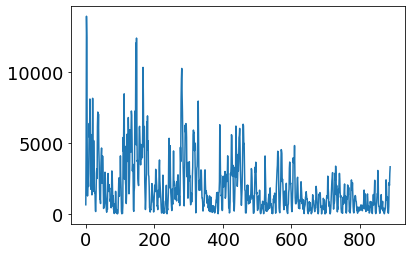

In [39]:
plt.plot(pspec_df.iloc[:,0].values)

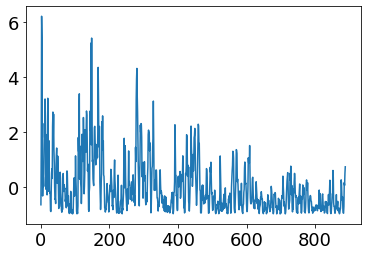

In [40]:
plt.plot(x[:,0])

In [41]:
x[:,0].mean()

6.394085361170756e-17

In [42]:
pca = PCA()

pca.fit(x)

X = pca.transform(x)

pca_df = pd.DataFrame(data = X)
print(pca_df.shape)
pca_df.head()

(889, 889)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888
0,0.807734,1.834957,-1.723047,-1.299097,2.768451,1.148706,1.459018,0.102138,0.068635,-0.092501,-2.397652,-1.337655,-0.822000,1.168360,-2.753972,0.110718,0.968194,-1.419422,0.711847,0.879384,-1.062874,0.650526,1.693756,-1.982409,1.773404,-0.555383,0.593705,0.398309,0.041996,2.227190,2.140161,1.909780,-1.565251,0.373985,-3.852725,0.419178,2.494639,2.014343,-0.141284,-0.753271,...,-8.543178e-06,-2.890640e-05,-2.358769e-05,8.077156e-06,3.665183e-05,1.476854e-05,1.075018e-05,3.160531e-06,1.436356e-06,1.580561e-05,-4.514371e-06,1.029731e-06,-6.831742e-06,2.492670e-06,-1.121116e-05,2.119293e-06,7.181435e-06,9.992609e-07,-1.614034e-07,1.492770e-05,-1.204669e-05,-8.081219e-06,5.390098e-06,-5.229137e-07,-9.020724e-07,-7.309941e-06,2.992590e-06,-3.387594e-06,-2.220108e-06,-6.033215e-07,4.880256e-06,-5.107768e-06,6.335268e-07,-2.546973e-06,-2.681700e-06,-8.656271e-07,3.210165e-06,6.326133e-07,1.998719e-07,6.245005e-16
1,262.893066,-35.350587,170.511735,-70.336545,-16.056395,2.826444,-2.099770,6.024629,-0.676849,0.541034,-1.148062,1.052473,-2.207423,-1.530371,-3.846126,-0.838280,-2.205393,-4.406485,1.080060,0.561248,-2.016056,0.233699,0.794560,-1.107220,-1.040624,0.152975,1.136073,0.593820,-0.272016,0.016265,-0.113886,0.581764,1.242842,-0.709194,0.203195,1.303157,-1.027453,0.179923,0.597044,-0.080197,...,-4.071132e-07,4.933088e-07,4.860422e-07,7.424414e-08,-8.755147e-08,1.083766e-07,4.189112e-07,-2.882310e-07,1.117477e-07,1.185422e-06,7.940940e-07,-5.839476e-08,3.388367e-07,-4.910896e-07,3.437644e-07,-2.482024e-07,-9.940332e-08,1.004573e-08,3.387601e-07,-1.179641e-07,3.483908e-07,3.793781e-07,2.861709e-07,3.261768e-07,1.665533e-07,-6.742090e-08,4.455502e-08,9.734498e-08,-1.951574e-08,-1.151306e-07,-2.655428e-07,6.468656e-08,1.385287e-08,4.717710e-08,6.105842e-08,-1.310323e-07,4.186197e-08,-2.713950e-08,-1.594506e-08,-8.881784e-15
2,133.711739,-132.772383,30.555554,109.375551,90.069129,-22.190749,-15.585571,0.190736,-0.399787,0.493910,-0.765505,2.282667,-0.226520,-0.205337,1.541033,1.522701,-0.113699,0.805793,-1.936139,1.987087,0.151763,0.056530,-0.474974,0.030668,0.469630,-0.459417,0.167228,-0.222948,-0.460235,-0.052093,0.600803,-0.383003,-0.381732,-0.013217,0.287277,-0.839055,0.258340,0.401174,-0.754158,0.139067,...,1.087112e-06,-1.400786e-06,2.640538e-07,5.814375e-08,-3.647342e-07,8.390950e-07,9.231425e-07,9.322521e-07,7.650906e-07,1.306938e-07,1.211476e-06,-1.485707e-07,1.190439e-06,-2.498552e-07,2.655816e-07,1.028259e-06,8.954551e-07,6.088580e-07,-1.894097e-07,-1.478827e-07,-6.822310e-07,3.562676e-07,1.867643e-07,-3.369751e-07,4.125711e-07,-5.741411e-07,-2.208143e-07,-1.599869e-07,-2.012808e-07,-6.162727e-08,2.870595e-07,-1.348011e-08,-4.835207e-07,-3.621053e-08,-3.744167e-07,2.401911e-07,8.679522e-08,-7.481692e-08,2.673411e-07,-2.353673e-14
3,163.933803,-53.608910,-13.777975,92.291270,-88.094320,73.890817,-12.740097,-3.602712,3.040190,-1.645495,-0.134320,-2.789866,0.402791,1.409627,-0.572116,-2.906508,0.356205,1.076883,1.483599,-0.801741,-0.987411,-0.356276,0.397298,-0.324127,0.902094,-0.245837,-0.822926,0.519078,0.468140,0.546284,0.250319,0.407789,0.766806,1.833524,-0.888902,0.637015,0.363772,0.138284,0.068304,0.237191,...,1.472750e-06,9.592161e-07,2.058204e-06,2.729302e-06,-2.377341e-06,-2.829199e-06,-8.758221e-07,-1.654750e-06,1.764955e-06,-1.758855e-06,-2.111866e-06,1.233465e-08,-1.334286e-06,-1.448888e-07,2.690492e-07,-7.991395e-07,-7.531470e-07,-1.712756e-07,-2.093334e-07,-6.000233e-07,1.356684e-06,-4.796962e-07,-3.570260e-07,-5.279123e-07,9.327203e-07,8.208482e-07,9.916238e-07,2.517573e-07,-4.797256e-07,-9.459079e-08,4.692637e-08,-1.324945e-07,2.765739e-07,5.685272e-07,1.520822e-07,-3.843310e-07,-2.806128e-07,2.472032e-07,-2.950112e-07,-5.329071e-15
4,62.509

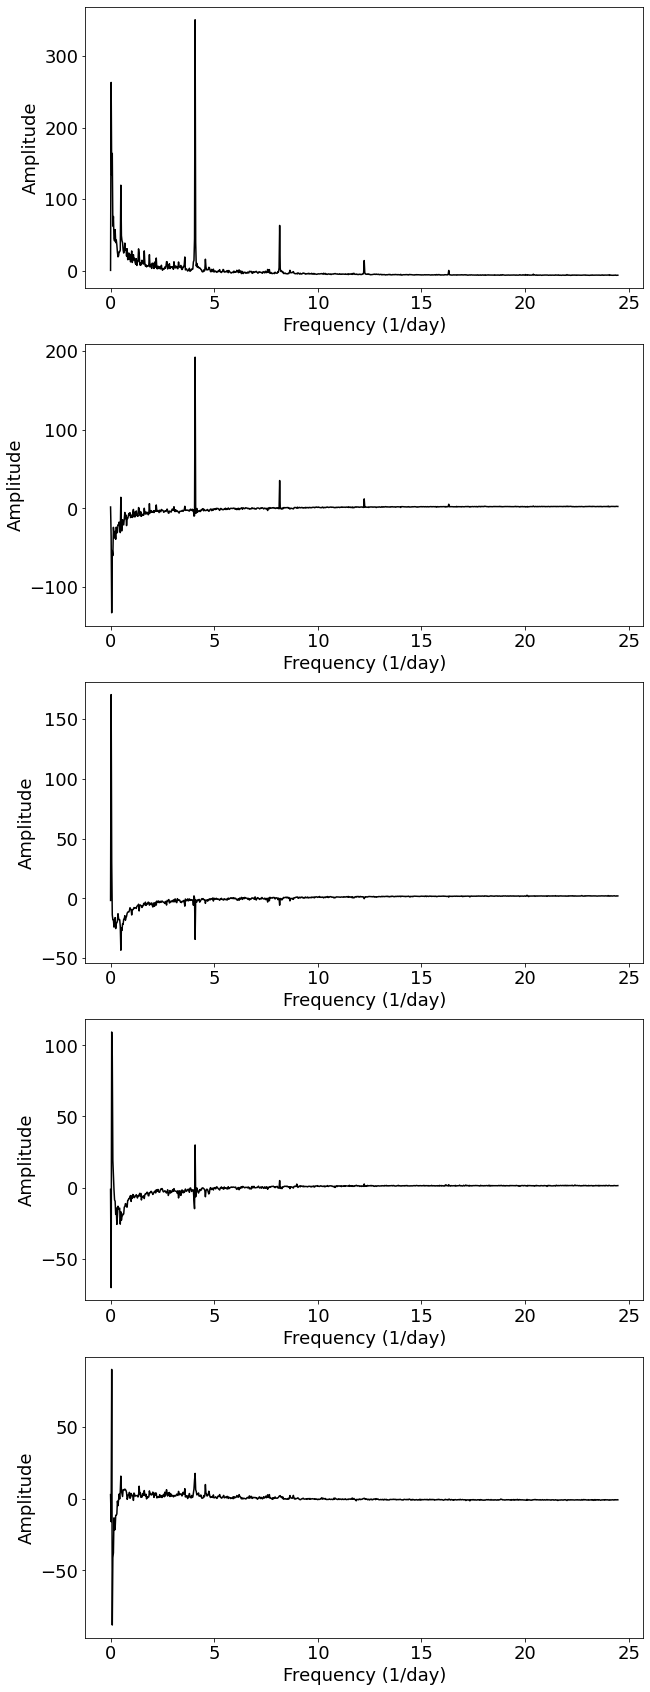

In [43]:
fig, axes = plt.subplots(5, figsize=(10,30))
p = 0
for i in range(5):
  axes[p].plot(frequency,pca_df[i], c='k')
  axes[p].set_ylabel('Amplitude')
  axes[p].set_xlabel('Frequency (1/day)')
  p += 1
plt.savefig('pspcs.png', dpi=100, bbox_inches='tight')

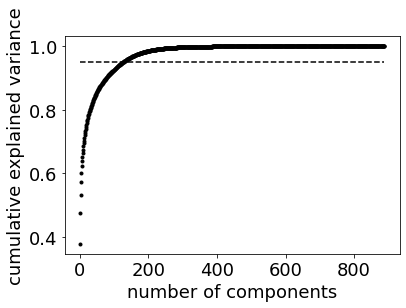

In [44]:
a = np.arange(0,889)
plt.scatter(a, np.cumsum(pca.explained_variance_ratio_), c='k', marker='.')
plt.plot(a, np.full(len(x),0.95),'k--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.savefig('expvar.png', bbox_inches='tight')

## Method 1: Removing First 2 Components entirely

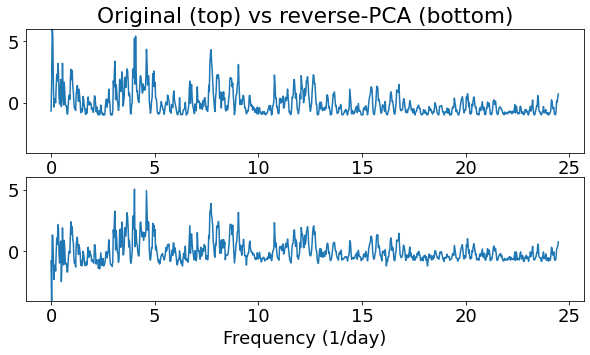

In [45]:
nComp = 200
Xhat = np.dot(pca.transform(x)[:,2:nComp], pca.components_[2:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,x[:,0])
axes[1].plot(frequency, Xhat[:,0])
axes[0].set_ylim(-4,6)
axes[1].set_ylim(-4,6)


axes[0].set_title('Original (top) vs reverse-PCA (bottom)')
plt.xlabel('Frequency (1/day)')
plt.savefig('pca_compare.png', dpi=100, bbox_inches='tight')

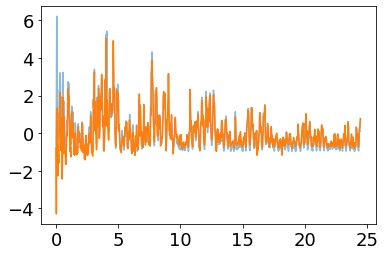

In [46]:
plt.plot(frequency,x[:,0], alpha=0.5)
plt.plot(frequency, Xhat[:,0]);

## Method 2: Bandpass Filtering First 2 Components

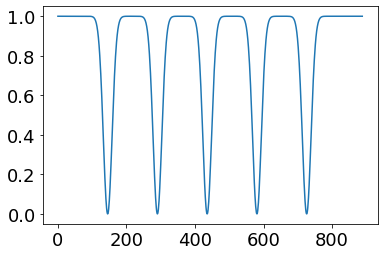

In [47]:
hrms = np.array([2,3,4,5]) * 4

filt = invgaussian(4,0.5,frequency)

for hrm in hrms:
  filt *= invgaussian(hrm,0.5,frequency)

plt.plot(filt)

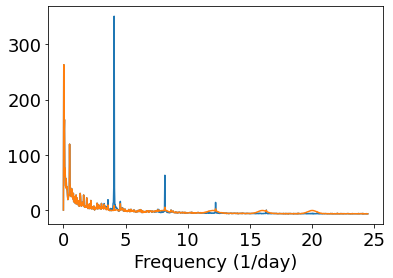

In [48]:
pca_filtered1 = pca_df[0]*filt
plt.plot(frequency,pca_df[0])
plt.plot(frequency,pca_filtered1)
plt.xlabel('Frequency (1/day)');

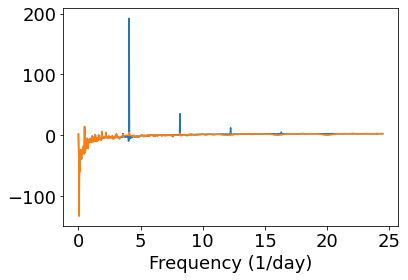

In [49]:
pca_filtered2 = pca_df[1]*filt
plt.plot(frequency,pca_df[1])
plt.plot(frequency,pca_filtered2)
plt.xlabel('Frequency (1/day)');

In [50]:
t = np.array([pca_filtered1,pca_filtered2])
filtered_transform = pca.transform(x).copy()
filtered_transform[0:2] = t

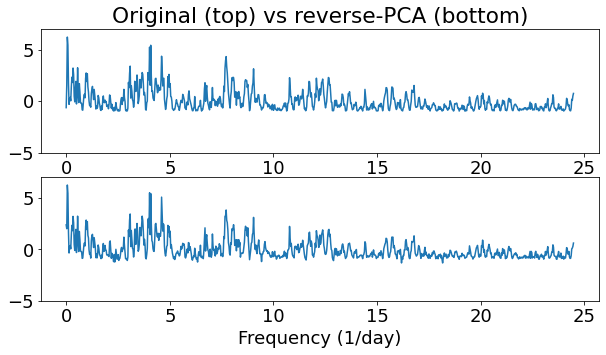

In [51]:
Xhat1 = np.dot(filtered_transform[:,0:nComp], pca.components_[0:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,x[:,0])
axes[1].plot(frequency,Xhat1[:,0])
axes[0].set_ylim(-5,7)
axes[1].set_ylim(-5,7)


axes[0].set_title('Original (top) vs reverse-PCA (bottom)')
plt.xlabel('Frequency (1/day)');

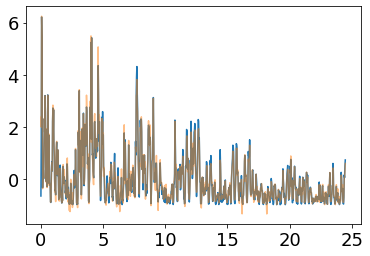

In [52]:
plt.plot(frequency,x[:,0])
plt.plot(frequency, Xhat1[:,0], alpha=0.5)

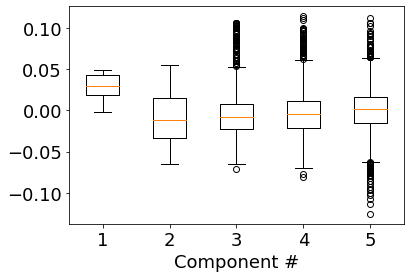

In [53]:
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot([pca.components_[0], pca.components_[1], pca.components_[2], pca.components_[3],pca.components_[4]])
plt.xlabel('Component #')
plt.savefig('box.png', dpi=100, bbox_inches='tight')
plt.show()

# PCA with DFTs

In [54]:
dft_dict = {}


for j, dft in enumerate(dfts):
  dft_dict["dft{0}".format(j)] = dft

dft_df = pd.DataFrame(data=dft_dict)

In [55]:
y = dft_df.values
y.real = scale(y.real, axis=0)
y.imag = scale(y.imag, axis=0)

In [56]:
print(y[:,0].real.mean(), y[:,0].imag.mean())

-1.498613756524396e-17 5.994455026097583e-18


In [57]:
print(y[:,0].real.std(), y[:,0].imag.std())

1.0 1.0


In [58]:
pca.fit(y.real)

Y = pca.transform(y.real)

pca2_df = pd.DataFrame(data = Y)
print(pca2_df.shape)
pca2_df.head()

(889, 889)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888
0,24.923992,8.955219,15.635020,3.971446,-5.951452,1.836308,-13.681921,8.401457,3.999238,-6.077615,-1.068657,1.474982,-1.645805,-1.616424,0.685663,2.145514,-2.869824,1.361525,-0.549355,1.475590,0.684906,-1.162980,0.850772,-0.980656,-0.494546,1.458197,0.983815,0.294475,0.202361,-4.178635,2.067631,0.153677,2.371474,-0.260411,-1.424688,1.598396,1.635015,3.481246,-0.295514,0.196649,...,-0.000738,0.002249,-0.000795,0.001444,-0.001003,-0.000285,-0.001623,0.001413,-0.000706,-0.001105,0.001210,-0.001440,-0.000357,0.002256,0.000679,0.000412,0.000482,0.000175,-0.000099,-0.001172,0.000048,-0.000523,-0.000529,-0.000376,0.000379,-0.000290,0.000486,-0.000128,0.000614,-0.000187,0.000112,0.000140,-0.000034,-0.000312,0.000079,0.000471,-0.000038,0.000389,-0.000027,3.330669e-16
1,-164.550373,48.365300,-23.271345,-66.962147,16.858072,34.495261,8.778201,57.139692,-29.939004,39.017126,26.674762,-32.497246,1.293580,5.772848,0.206606,6.107087,-3.932739,9.693123,3.566455,-3.130675,4.598335,-1.298564,-9.465520,2.265417,4.785046,-2.604005,-5.081671,3.625777,0.379423,-0.384116,2.891249,-0.641448,1.751003,0.025391,-0.332571,2.368539,1.502011,-2.616666,0.392755,-1.829696,...,-0.000111,-0.000034,-0.000106,0.000070,-0.000262,0.000268,-0.000164,0.000305,-0.000040,-0.000114,-0.000057,-0.000101,-0.000225,0.000157,0.000047,0.000025,0.000004,0.000023,-0.000062,0.000035,-0.000134,-0.000028,0.000075,0.000028,-0.000128,0.000075,-0.000066,0.000144,-0.000153,0.000029,0.000141,-0.000049,0.000055,0.000116,0.000087,0.000017,0.000021,-0.000016,-0.000077,-1.790235e-14
2,-38.971083,65.903416,87.310729,85.817145,49.251650,-5.948170,22.723288,-11.292056,-45.751032,24.817780,20.392206,4.495861,-1.781741,-8.465567,-2.537936,-1.794132,2.475861,-1.366737,0.557513,-0.106087,-2.484489,0.775183,-4.337304,-2.765344,2.327740,0.759261,-2.440157,-1.823960,0.494908,3.185588,1.129472,0.077203,1.404294,-0.137041,-1.718369,1.490961,-1.304647,0.075940,-2.613216,-2.611662,...,0.000125,-0.000420,-0.000137,-0.000222,-0.000143,0.000183,-0.000148,-0.000190,-0.000240,-0.000076,0.000219,-0.000175,-0.000038,-0.000317,-0.000207,-0.000084,-0.000397,0.000090,-0.000017,0.000384,0.000144,-0.000059,-0.000130,0.000118,-0.000178,-0.000030,0.000120,-0.000062,0.000136,-0.000168,-0.000016,0.000024,0.000061,0.000176,0.000043,-0.000036,0.000045,-0.000057,-0.000071,-2.242651e-14
3,-57.979332,31.716435,-12.094457,-3.067509,58.286110,15.342419,-20.301201,-42.336886,78.206373,20.995859,14.303114,-14.262388,-6.173768,-26.838439,-16.155473,-4.424746,-11.955101,1.431688,-7.580396,3.325695,2.028878,2.719733,-8.720586,1.120143,9.226172,2.904526,1.336377,2.758008,-5.790531,1.787968,0.325429,0.722330,1.349638,7.119144,0.203048,1.139408,4.999917,0.279057,-0.966031,-0.970756,...,0.000117,0.000528,0.000148,-0.000012,0.000229,0.000377,0.000431,0.000252,0.000122,-0.000320,0.000117,-0.000210,-0.000035,0.000031,0.000020,0.000007,-0.000026,0.000116,-0.000257,0.000021,0.000025,0.000153,-0.000009,-0.000327,0.000558,0.000019,0.000130,0.000282,0.000070,-0.000314,-0.000049,0.000039,-0.000067,-0.000174,-0.000114,-0.000072,0.000016,0.000007,0.000030,3.330669e-15
4,-28.387065,28.235104,21.512812,8.578019,10.822437,27.271295,-29.172046,-22.635463,12.866296,-23.364542,8.551813,-24.328370,40.770023,54.043629,31.958773,-27.450325,21.323544,6.626853,7.370511,5.052105,11.481068,5.157544,-0.132559,-8.459515,-0.157476,-4.526453,-0.178807,0.898224,0.396624,-3.481158,6.235809,-1.247114,-4.935584,-0.890219,-0.383043,2.244796,2.532029,-0.857657,-1.004724,1.328326,...,0.000227,0.000249,-0.000177,-0.000131,-0.000113,-0.000247,-0.000083,-0.000315,0.000026,0.000047,-0.000170,-0.000396,0.000018,-0.000344,-0.000146,-0.000144,0.000229,0.000029,-0.000009,-0.000084,0.000021,-0.000116,-0.000

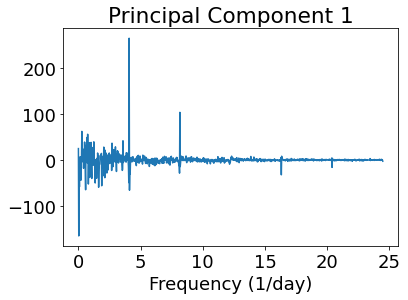

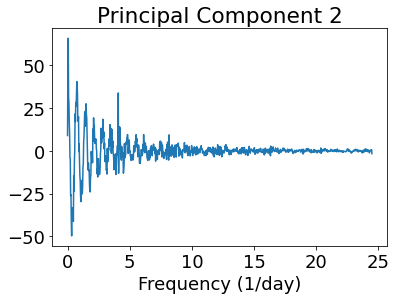

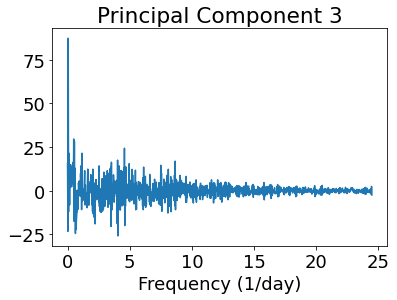

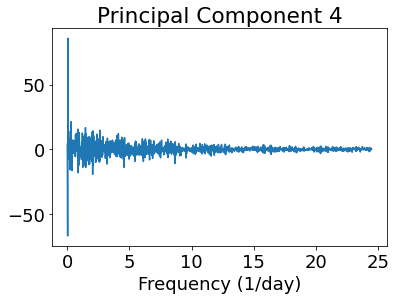

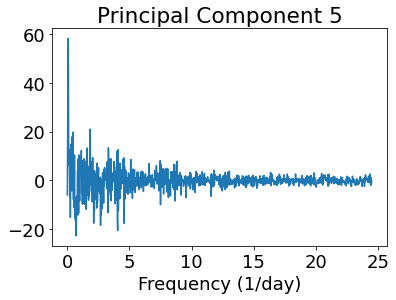

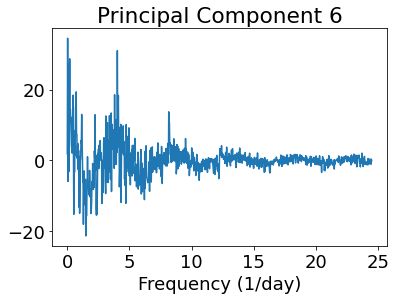

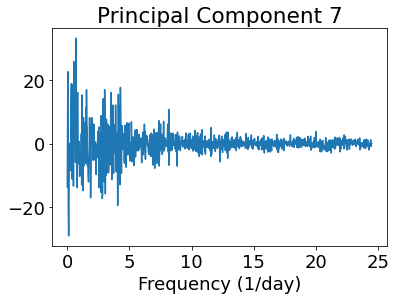

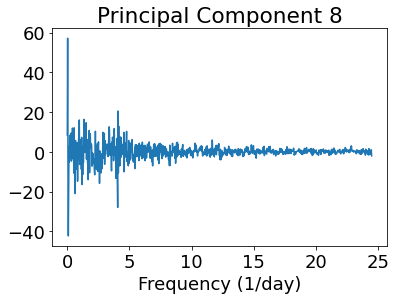

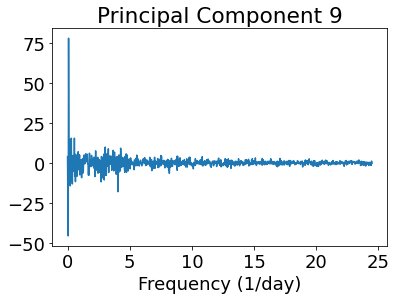

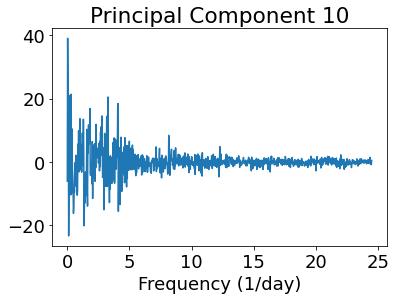

In [59]:
for i in range(0,10):
  plt.plot(frequency,pca2_df[i])
  plt.title('Principal Component {}'.format(i+1))
  plt.xlabel('Frequency (1/day)')
  plt.show()

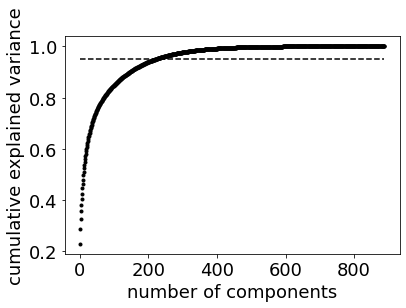

In [60]:
a = np.arange(889)
plt.scatter(a, np.cumsum(pca.explained_variance_ratio_), c='k', marker='.')
plt.plot(a, np.full(len(a),0.95),'k--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.savefig('expvar3.png', bbox_inches='tight')

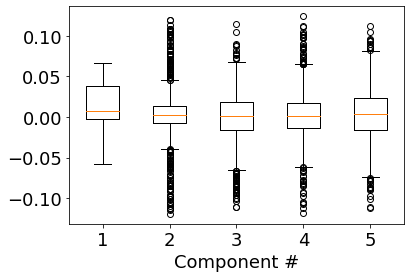

In [61]:
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot([pca.components_[0], pca.components_[1], pca.components_[2], pca.components_[3],pca.components_[4]])
plt.xlabel('Component #')
plt.savefig('box2.png', dpi=100, bbox_inches='tight')
plt.show()

## Removing 1st Component

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


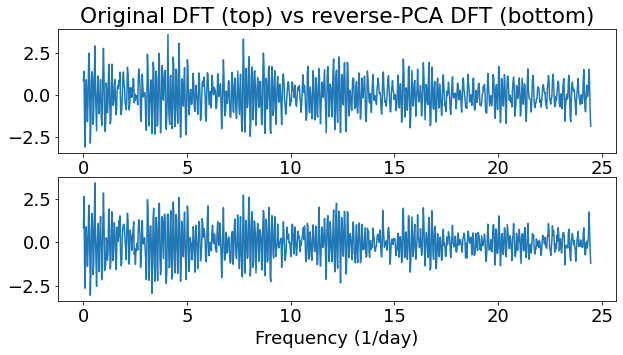

In [62]:
nComp = 200
Yhat = np.dot(pca.transform(y.real)[:,2:nComp], pca.components_[2:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,y[:,0])
axes[1].plot(frequency, Yhat[:,0])
#axes[0].set_ylim(-4,6)
#axes[1].set_ylim(-4,6)


axes[0].set_title('Original DFT (top) vs reverse-PCA DFT (bottom)')
plt.xlabel('Frequency (1/day)')
plt.savefig('pca2_compare.png', dpi=100, bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


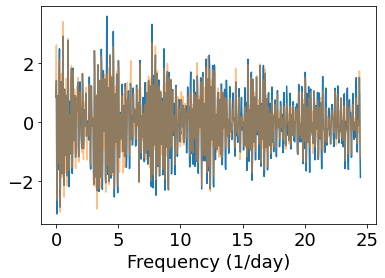

In [63]:
plt.plot(frequency,y[:,0])
plt.plot(frequency, Yhat[:,0],alpha=0.5)
plt.xlabel('Frequency (1/day)');

In [64]:
Yhatc = Yhat + (1j)*y.imag

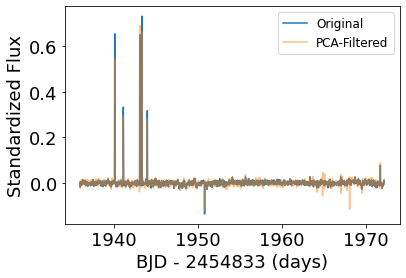

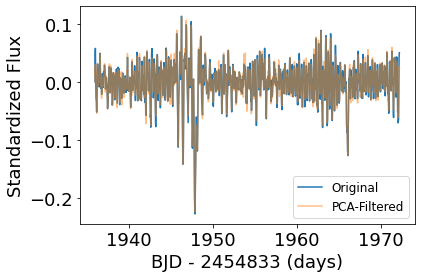

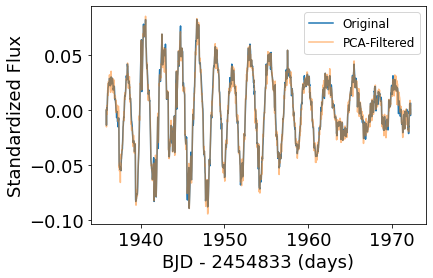

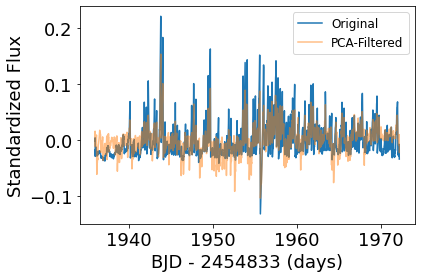

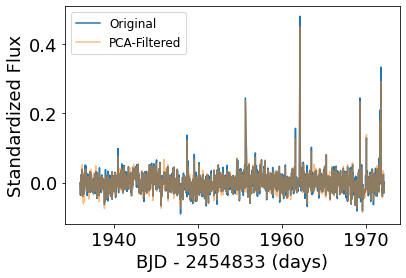

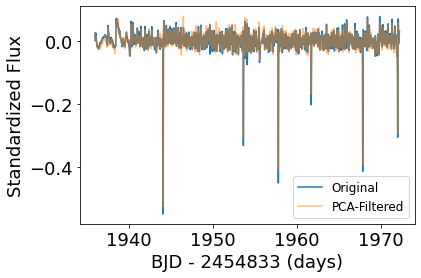

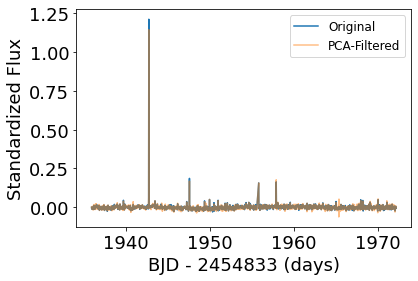

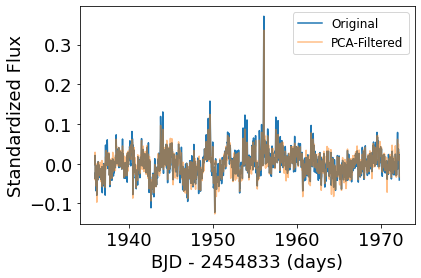

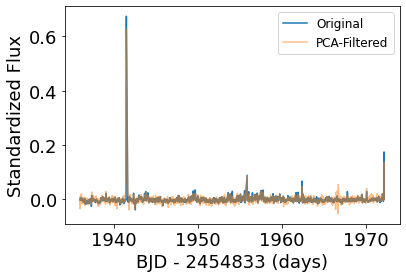

In [65]:
for i in range(0,900,100):
  plt.plot(bjds[i],np.fft.irfft(y[:,i]), label='Original')
  plt.plot(bjds[i],np.fft.irfft(Yhatc[:,i]), alpha=0.5, label='PCA-Filtered')
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Standardized Flux')
  plt.legend(fontsize=12)
  plt.show()

## Bandpass Filtering 1st Component

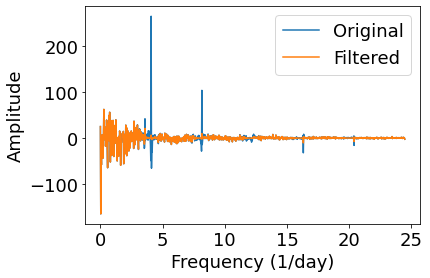

In [66]:
pca2_filtered = pca2_df[0]*filt
plt.plot(frequency,pca2_df[0], label='Original')
plt.plot(frequency,pca2_filtered, label='Filtered')
plt.legend()
plt.ylabel('Amplitude')
plt.xlabel('Frequency (1/day)')
plt.savefig('dftfiltered.png', dpi=100, bbox_inches='tight')

In [67]:
t = np.array([pca2_filtered])
filtered_transform2 = pca.transform(y.real).copy()
filtered_transform2[0] = t

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


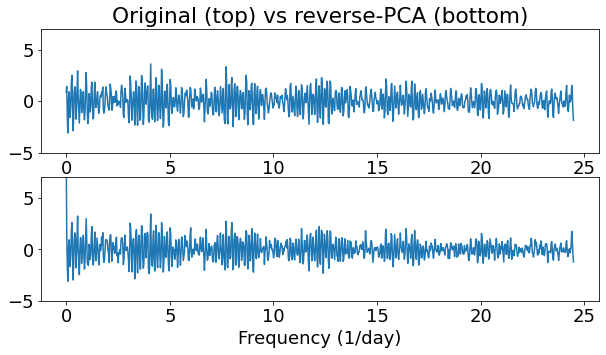

In [68]:
Yhat1 = np.dot(filtered_transform2[:,0:nComp], pca.components_[0:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,y[:,0])
axes[1].plot(frequency, Yhat1[:,0])
axes[0].set_ylim(-5,7)
axes[1].set_ylim(-5,7)


axes[0].set_title('Original (top) vs reverse-PCA (bottom)')
plt.xlabel('Frequency (1/day)')
plt.savefig('dftcompare.png', dpi=100, bbox_inches='tight')

In [69]:
Yhat1c = Yhat1 + (1j)*y.imag

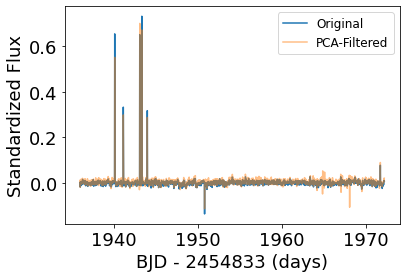

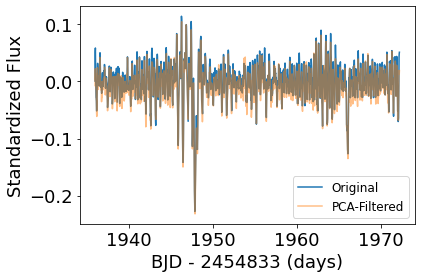

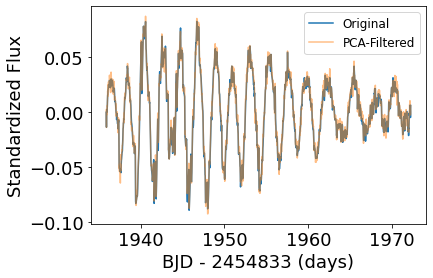

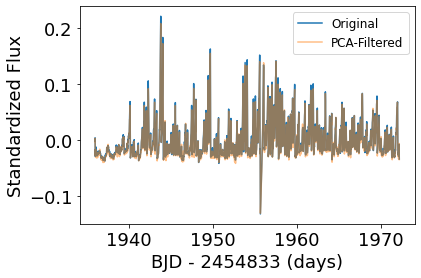

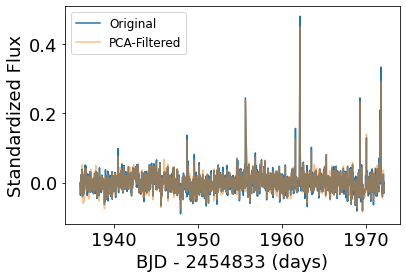

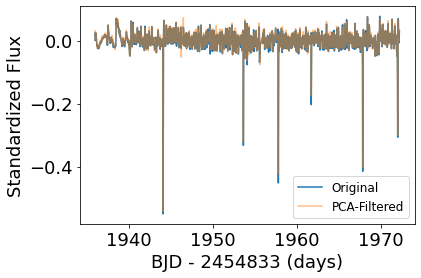

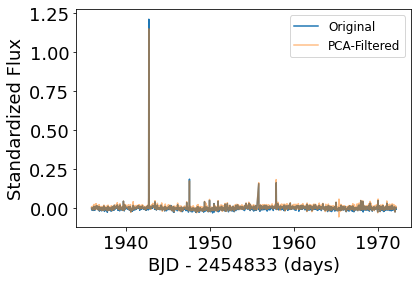

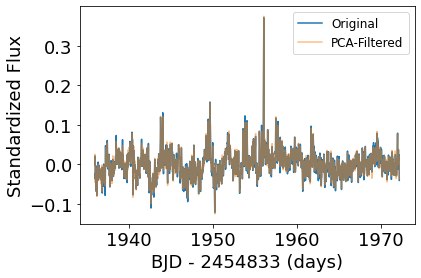

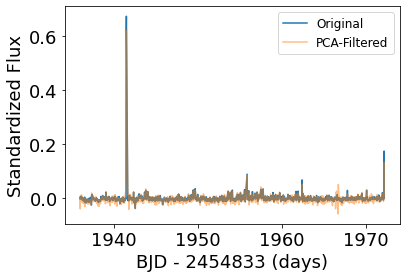

In [70]:
for i in range(0,900,100):
  plt.plot(bjds[i],np.fft.irfft(y[:,i]), label='Original')
  plt.plot(bjds[i],np.fft.irfft(Yhat1c[:,i]), alpha=0.5, label='PCA-Filtered')
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Standardized Flux')
  plt.legend(fontsize=12)
  plt.show()

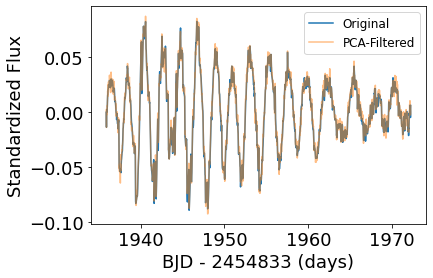

In [71]:
plt.plot(bjds[200],np.fft.irfft(y[:,200]), label='Original')
plt.plot(bjds[200],np.fft.irfft(Yhat1c[:,200]), alpha=0.5, label='PCA-Filtered')
plt.xlabel('BJD - 2454833 (days)')
plt.ylabel('Standardized Flux')
plt.legend(fontsize=12)
plt.savefig('lc1filter.png', dpi=100, bbox_inches='tight')
plt.show()

# Investigating TOIs

In [72]:
toiseries = []
for filename in dtoi:
  toiseries.append(dtoi[filename])

In [73]:
bjds = toiseries[::3]
fluxes = toiseries[1::3]
fluxerrs = toiseries[2::3]

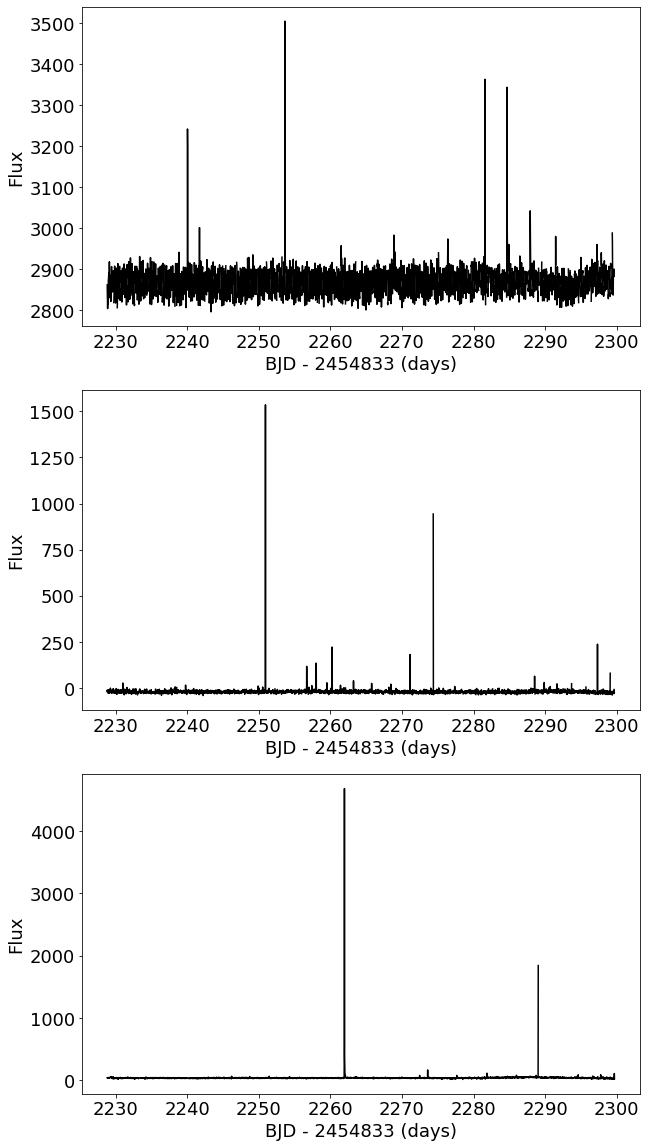

In [74]:
fig, axes = plt.subplots(3, figsize=(10,20))
p = 0
for i in range(3):
  axes[p].plot(bjds[i], fluxes[i], c='k')
  axes[p].set_ylabel('Flux')
  axes[p].set_xlabel('BJD - 2454833 (days)')
  p += 1

In [75]:
#Normalize flux values
for i in range(len(fluxes)):
  fluxes[i] = (fluxes[i] - np.nanmean(fluxes[i])) / np.nanstd(fluxes[i])

In [76]:
#Test for NaNs:
a = []
for j in range(len(bjds)):
  a.append(np.any(np.isnan(bjds[j]) == True))
  a.append(np.any(np.isnan(fluxes[j]) == True))
  a.append(np.any(np.isnan(fluxerrs[j]) == True))
np.any(a)#If NaNs exist, this returns True

True

In [77]:
#Interpolate the flux arrays:
for i, flux in enumerate(fluxes):
  fluxes[i] = lin_interp_nans(bjds[i], flux)

In [78]:
#Test for NaNs:
a = []
for j in range(len(bjds)):
  a.append(np.any(np.isnan(bjds[j]) == True))
  a.append(np.any(np.isnan(fluxes[j]) == True))
  a.append(np.any(np.isnan(fluxerrs[j]) == True))
np.any(a)#If NaNs exist, this returns True

True

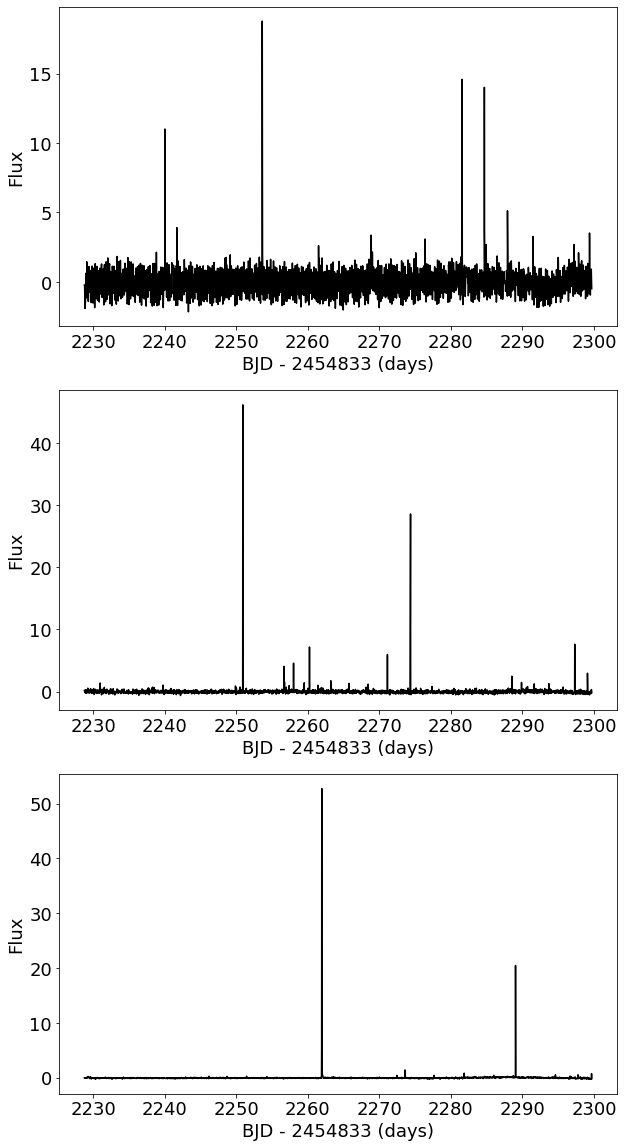

In [79]:
fig, axes = plt.subplots(3, figsize=(10,20))
p = 0
for i in range(3):
  axes[p].plot(bjds[i], fluxes[i], c='k')
  axes[p].set_ylabel('Flux')
  axes[p].set_xlabel('BJD - 2454833 (days)')
  p += 1

## FFT

In [80]:
dfts = []
pspectra = []
for i, flux in enumerate(fluxes):
  Low_cutoff, High_cutoff, F_sample = 4, 6, np.diff(bjds[i])[0]
  Spectrum, frequency, Filtered_spectrum, Filtered_signal, Low_freq, High_freq = bandpass_ifft(bjds[i], flux, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 1, Filter='Gaussian')

  dfts.append(Spectrum)
  pspectra.append(np.abs(Spectrum)**2)

## PCA

In [176]:
dft_dict = {}


for j, dft in enumerate(dfts):
  dft_dict["dft{0}".format(j)] = dft

dft_df = pd.DataFrame(data=dft_dict)

In [177]:
y = dft_df.values
y.real = scale(y.real, axis=0)
y.imag = scale(y.imag, axis=0)

In [178]:
pca = PCA()

pca.fit(y.real)

Y = pca.transform(y.real)

pca2_df = pd.DataFrame(data = Y)
print(pca2_df.shape)
pca2_df.head()

(1736, 3)


,0,1,2
0,0.114506,0.449824,-0.219506
1,-0.280838,-1.416668,0.962213
2,-2.215941,0.076963,-3.155765
3,-0.544010,2.014548,3.483418
4,0.682992,-2.174005,0.478367


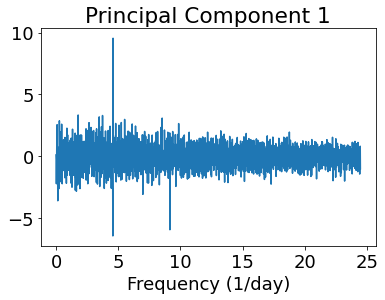

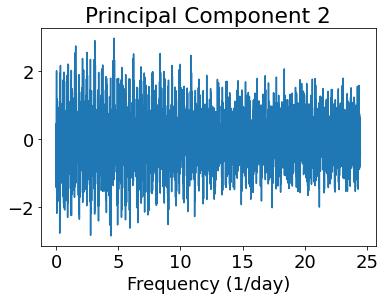

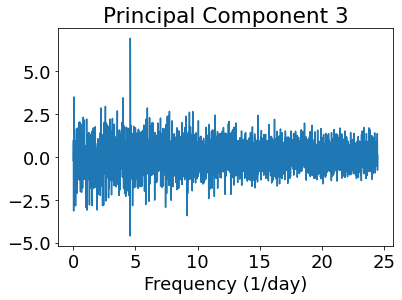

In [179]:
for i in range(3):
  plt.plot(frequency,pca2_df[i])
  plt.title('Principal Component {}'.format(i+1))
  plt.xlabel('Frequency (1/day)')
  plt.show()

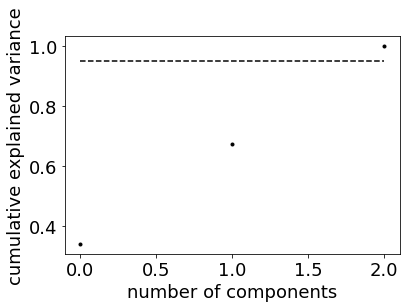

In [180]:
a = np.arange(3)
plt.scatter(a, np.cumsum(pca.explained_variance_ratio_), c='k', marker='.')
plt.plot(a, np.full(len(a),0.95),'k--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

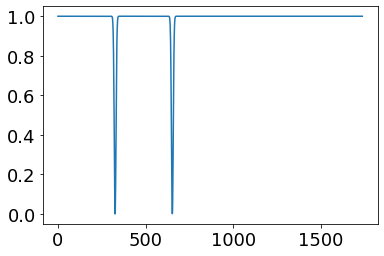

In [181]:
fund = 4.6

hrms = np.array([2]) * fund

filt = invgaussian(fund,0.1,frequency)

for hrm in hrms:
  filt *= invgaussian(hrm,0.1,frequency)

plt.plot(filt)

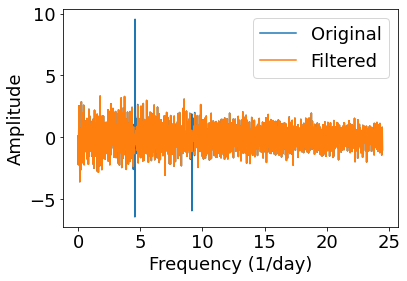

In [182]:
pca2_filtered = pca2_df[0]*filt
plt.plot(frequency,pca2_df[0], label='Original')
plt.plot(frequency,pca2_filtered, label='Filtered')
plt.legend()
plt.ylabel('Amplitude')
plt.xlabel('Frequency (1/day)');

In [183]:
t = np.array([pca2_filtered])
filtered_transform2 = pca.transform(y.real).copy()
filtered_transform2[:,0] = t

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


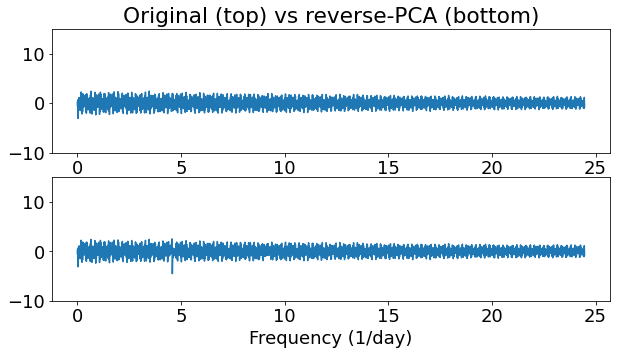

In [184]:
nComp = 3
Yhat1 = np.dot(filtered_transform2[:,0:nComp], pca.components_[0:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,y[:,2])
axes[1].plot(frequency, Yhat1[:,2])
axes[0].set_ylim(-10,15)
axes[1].set_ylim(-10,15)
axes[0].set_title('Original (top) vs reverse-PCA (bottom)')

plt.xlabel('Frequency (1/day)');

In [185]:
Yhat1c = Yhat1 + (1j)*y.imag

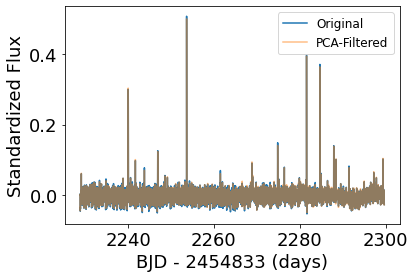

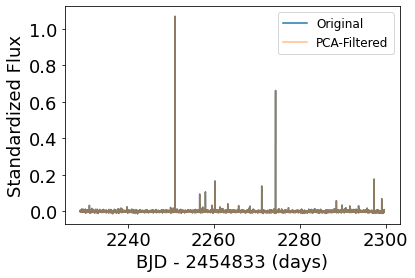

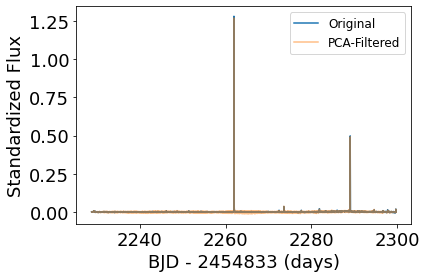

In [186]:
for i in range(3):
  #fig = plt.figure(figsize=(20,10))
  plt.plot(bjds[i],np.fft.irfft(y[:,i]), label='Original')
  plt.plot(bjds[i],np.fft.irfft(Yhat1c[:,i]), alpha=0.5, label='PCA-Filtered')
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Standardized Flux')
  plt.legend(fontsize=12)
  if i == 1 or 2:
   plt.savefig('toicomp{}.png'.format(i), dpi=100, bbox_inches='tight')
  plt.show()

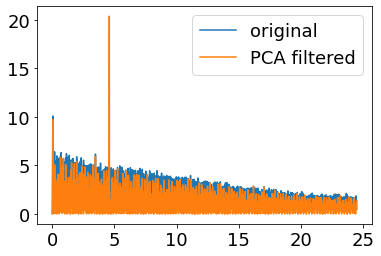

In [187]:
plt.plot(frequency, np.abs(y[:,2])**2, label='original')
plt.plot(frequency, np.abs(Yhat1[:,2])**2, label='PCA filtered')
#plt.xlim(0,.5)
plt.legend();

## Check periodicity

In [188]:
!pip install PyAstronomy

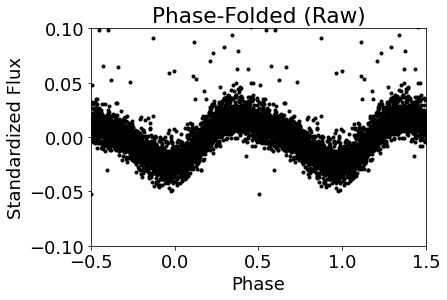

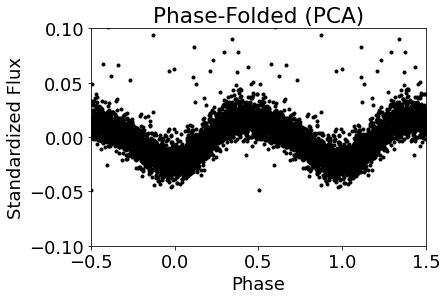

In [189]:
from PyAstronomy.pyasl import foldAt

period = 0.2185
dur = np.nanmax(bjds[0]) - np.nanmin(bjds[0])

# Obtain the phases with respect to some
# reference point (in this case T0=217.4)
phases = foldAt(bjds[0], period, T0=np.nanmin(bjds[0]))

# Sort with respect to phase
# First, get the order of indices ...
sortIndi = np.argsort(phases)
# ... and, second, rearrange the arrays.
phases = phases[sortIndi]
# Plot the result

plt.plot(phases-0.5, np.fft.irfft(y[:,0])[sortIndi], 'k.')
plt.plot(phases+0.5, np.fft.irfft(y[:,0])[sortIndi], 'k.')
plt.xlabel('Phase')
plt.ylabel('Standardized Flux')
plt.title('Phase-Folded (Raw)')
plt.xlim(-0.5,1.5)
plt.ylim(-0.1,0.1)
plt.savefig('phasefold1.png',dpi=100,bbox_inches='tight')
plt.show()

plt.plot(phases-0.5, np.fft.irfft(Yhat1c[:,0])[sortIndi], 'k.')
plt.plot(phases+0.5, np.fft.irfft(Yhat1c[:,0])[sortIndi], 'k.')
plt.xlabel('Phase')
plt.ylabel('Standardized Flux')
plt.title('Phase-Folded (PCA)')
plt.xlim(-0.5,1.5)
plt.ylim(-0.1,0.1)
plt.savefig('phasefold2.png',dpi=100,bbox_inches='tight')
plt.show()

## Model flares

In [194]:
flares = [2253.65107,
          2240.04075,
          2281.57290,
          2284.68258,
          2287.91009,
          2268.87127,
          2295.39965,
          2299.37770,
          2291.45770,
          2248.59421,
          2261.51045,
          2269.02792,
          2249.17243,
          2276.02709,
          2229.08574,
          2293.30131,
          2295.02575,
          2258.54786,
          2284.92844,
          2238.85706,
          2251.42265,
          2249.41148,
         ]